In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
# load the already done pca on the dataset
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score,plot_roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Exploratory Data Analysis

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# checking for NAN values
data.isnull().values.any()

False

In [7]:
# plot bar graph showing the distribution of anmomolous to non-anomolous transactions
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes
# got  - 492 fraud trnasactions

0    284315
1       492
Name: Class, dtype: int64

<BarContainer object of 2 artists>

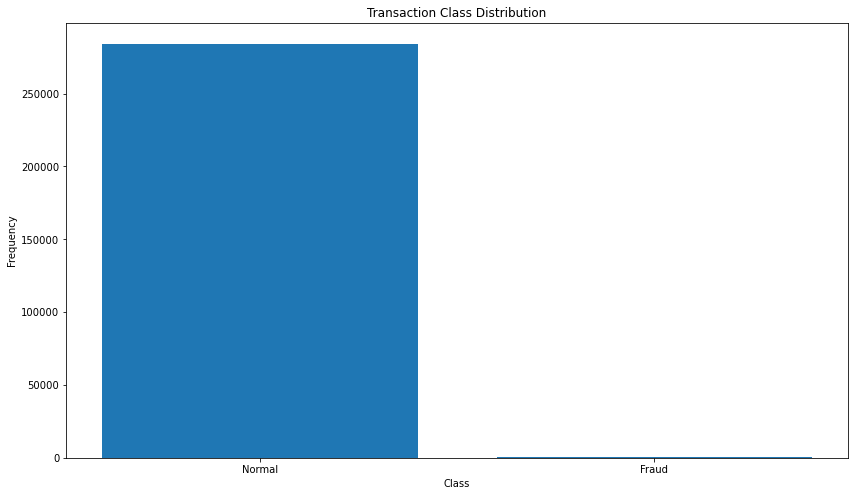

In [8]:
names = ["Normal","Fraud"]
values = count_classes
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(names,values)

In [9]:
# separating the fraud and normal data
normal = data[data['Class']==0]
fraud = data[data['Class']==1]
print(normal.shape)
print(fraud.shape)

(284315, 31)
(492, 31)


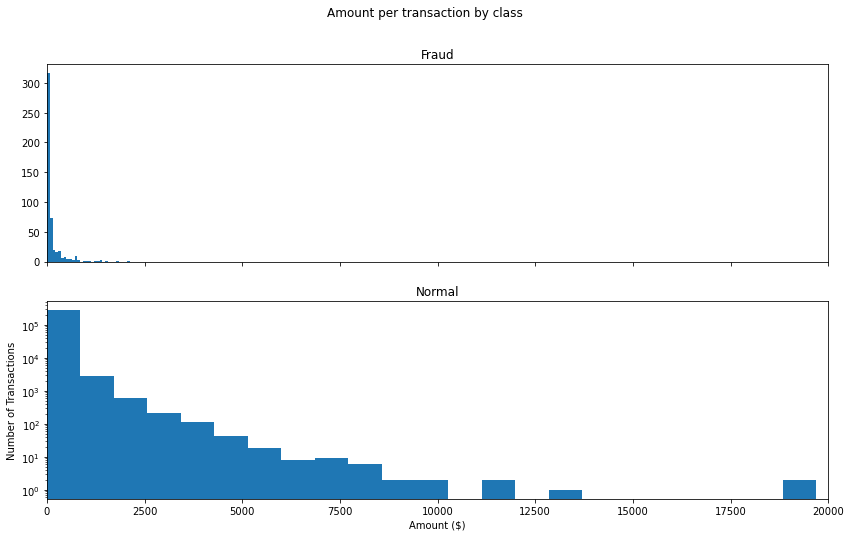

In [10]:
# Amount per transaction distrbution
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 30
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

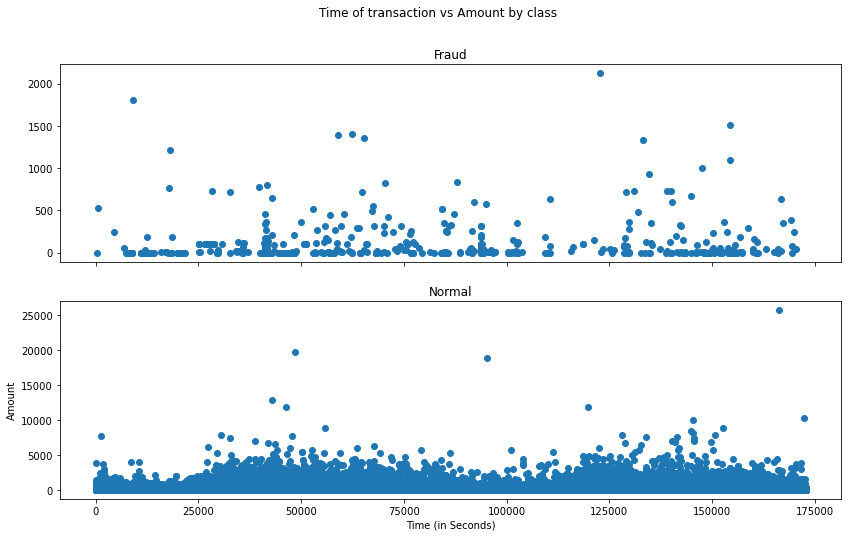

In [11]:
# time of trnasaction vs amount by class
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

From the second plot, we can observe that fraudulent transactions occur at the same time as normal transaction, making time an irrelevant factor. From the first plot, we can see that most of the fraudulent transactions are small amount transactions. This is however not a huge differentiating feature since majority of normal transactions are also small amount transactions.

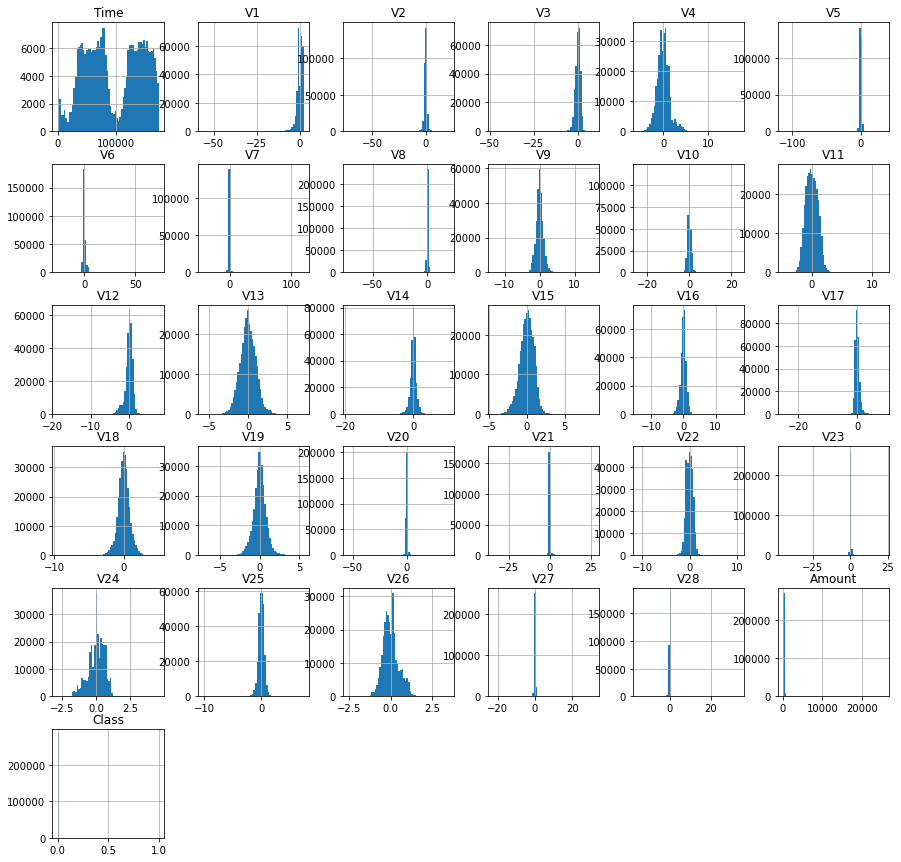

In [12]:
data.hist(figsize=(15,15), bins = 64)
plt.show()

In [13]:
#data.drop(['Time', 'V1', 'V24'], axis=1, inplace=True)
data.drop(['Time', 'V24'], axis=1, inplace=True)

In [14]:
# lets reduce our dataset to say 30% as it is a huge dataset with more than 284k+ objects
df= data.sample(frac = 0.2,random_state=1)
df.shape

(56961, 29)

In [15]:
data.shape
# you see the difference , original data had 284k examples while the reduced have 85k

(284807, 29)

In [16]:
# now lets see the distribution again of normal vs fraud transaction
Fraud = df[df['Class']==1]
Normal = df[df['Class']==0]
print(Fraud.shape,Normal.shape)
# you see about 135 fraud cases now

(87, 29) (56874, 29)


We have just 0.16% fraudulent transactions in the dataset. This means that a random guess by the model should yield 0.16% accuracy for fraudulent transactions

In [17]:
outlier_fraction = len(Fraud)/float(len(Normal))
outlier_fraction 

0.0015296972254457222

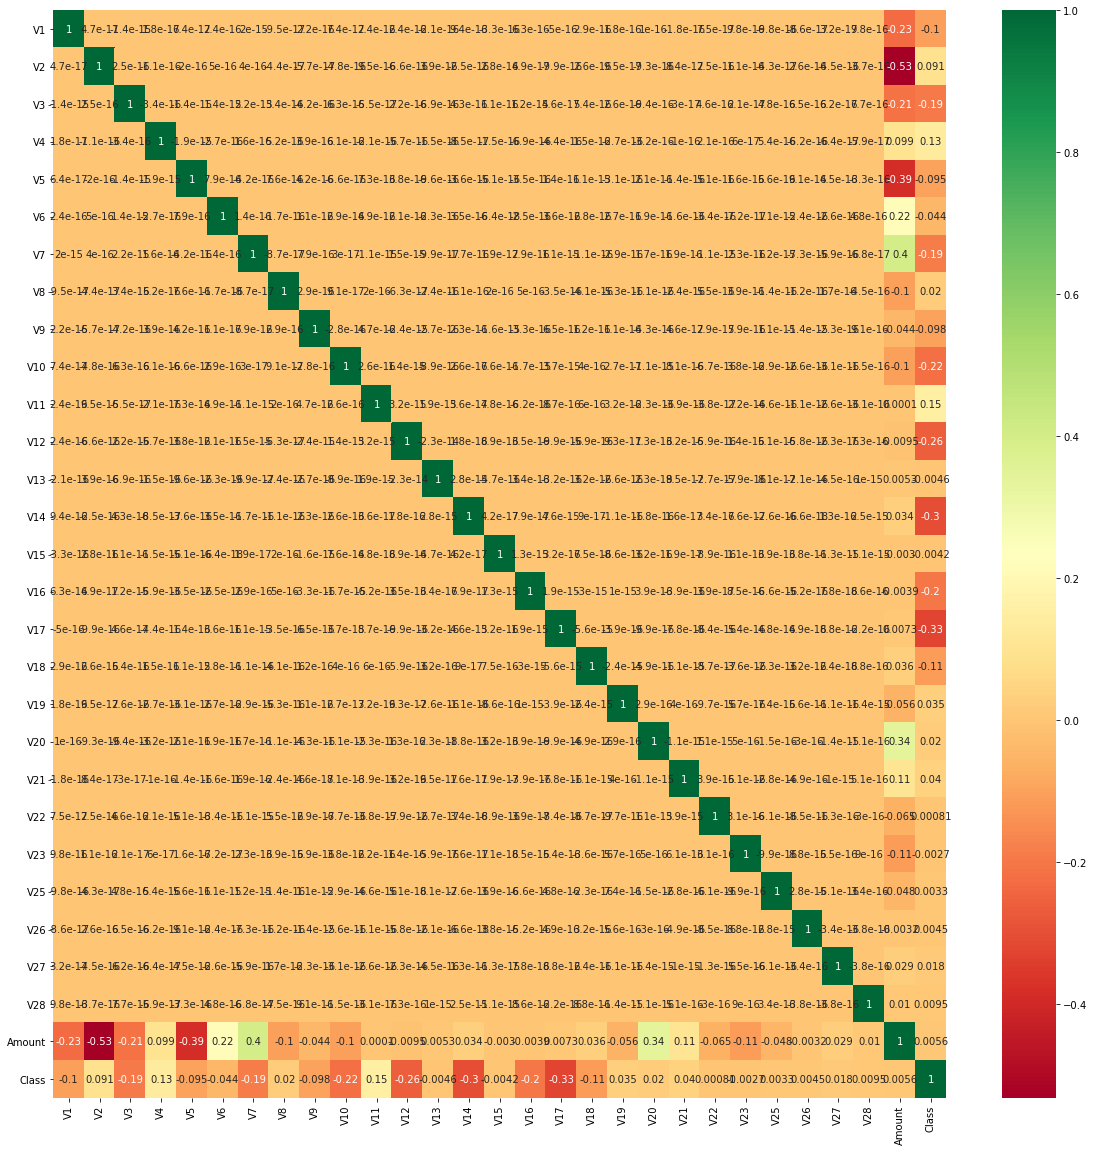

In [18]:
#Correlation using heatmap
import seaborn as sns
#get correlations of each features in dataset
corrmat =df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Building Models and Model Prediction

In [69]:
#Create independent and Dependent Features
columns = df.columns.tolist()  # all columns
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]   # removing "Class" from our columns list
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(56961, 28)
(56961,)


In [70]:
# Train_test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [21]:
print(y_test)

150340    0
130939    0
150066    0
284285    0
196462    0
         ..
196504    0
39304     0
183807    0
37174     0
138361    0
Name: Class, Length: 18798, dtype: int64


## Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [ ]:
n_outliers = len(Fraud)
n_outliers

In [131]:
#plotting roc curve
def plot_roc(y_test,preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Local Outlier factor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski',p=2, metric_params=None, contamination=outlier_fraction)
y_train_pred = clf.fit_predict(X_train)
#print(y_pred)
scores_prediction = clf.negative_outlier_factor_
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# on test data
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [27]:
import itertools
classes = np.array(['0','1'])
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])


In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

In [ ]:
cm_test = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))   # f1 - score - 0.40 Bad

In [ ]:
#plot_roc_curve(clf,X_test,y_test_pred)

## Isolation Forest

In [123]:
clf = IsolationForest(n_estimators=100, max_samples=len(X),contamination=outlier_fraction,random_state=state, verbose=0)
clf.fit(X_train)
#scores_prediction = clf.decision_function(X)
y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# On test set
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:288: UserWarning: max_samples (284807) is greater than the total number of samples (190820). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_iforest.py:288: UserWarning: max_samples (284807) is greater than the total number of samples (93987). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


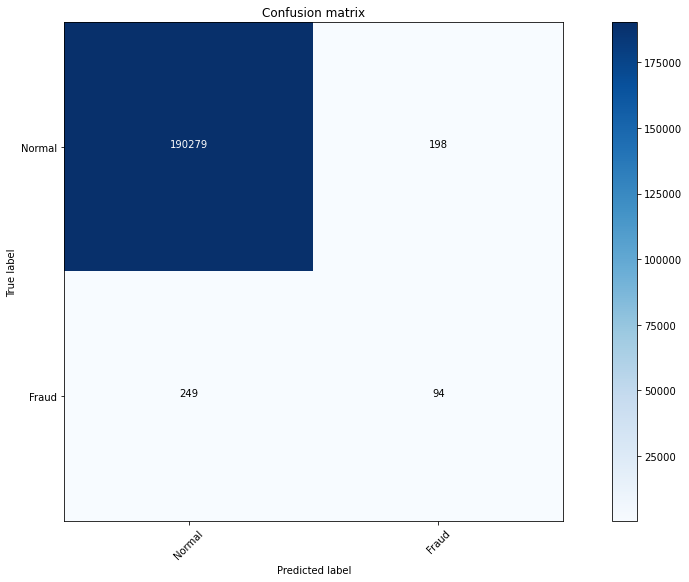

In [124]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

In [125]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")

Total fraudulent transactions detected in training set: 94 / 343
Total non-fraudulent transactions detected in training set: 190279 / 190477
Probability to detect a fraudulent transaction in the training set: 0.27405247813411077
Probability to detect a non-fraudulent transaction in the training set: 0.9989605044178562
Accuracy of unsupervised anomaly detection model on the training set: 99.76574782517555%


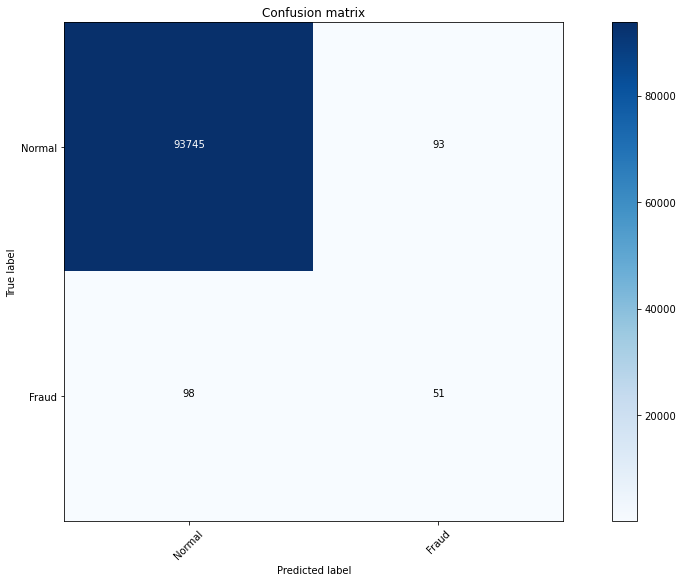

In [126]:
cm_test = confusion_matrix( y_test,y_test_pred)
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [127]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

Total fraudulent transactions detected in test set: 51 / 149
Total non-fraudulent transactions detected in test set: 93745 / 93838
Probability to detect a fraudulent transaction in the test set: 0.3422818791946309
Probability to detect a non-fraudulent transaction in the test set: 0.9990089302841066
Accuracy of unsupervised anomaly detection model on the test set: 99.7967804058008%
ROC_AUC_score : 0.670645


In [128]:
print(classification_report(y_test,y_test_pred))  # f1 - score - 0.35 - BAd

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.35      0.34      0.35       149

    accuracy                           1.00     93987
   macro avg       0.68      0.67      0.67     93987
weighted avg       1.00      1.00      1.00     93987



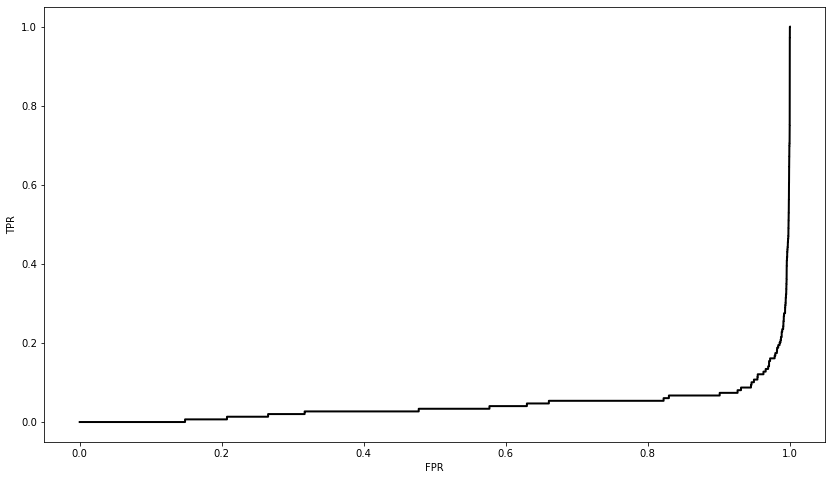

ROC_AUC_score : 0.041336


In [129]:
y_pred = clf.decision_function(X_test)

from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))

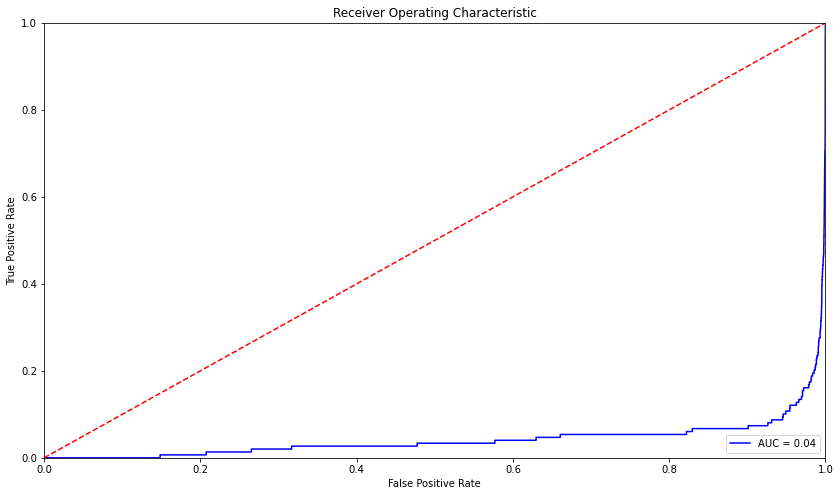

In [132]:
plot_roc(y_test,y_pred)

The results we've got through this model are far from ideal. We have not been able to classify fraudulent transactions efficiently despite having a high accuracy (which is not a good metric to measure performance on a skewed dataset anyways). Supervised learning for anomaly detection is the move fot this dataset since we have the labels. One reason why unsupervised learning did not perform well enough is because most of the fraudulent transactions did not have much unusual characteristics regarding them which can be well separated from normal transactions and I feel that's the main reason they provided us with a labelled dataset. Anyways, this notebook represents how unsupervised learning captures anomalies. The accuracy of detecting anomalies on the test set is 25%, which is way better than a random guess (the fraction of anomalies in the dataset is < 0.1%). I have also implemented the supervised learning model for this dataset, which works extremely well.

## Supervised SVM

In [ ]:
from sklearn import preprocessing, svm
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [ ]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test,predictions))   # f1 - score - 0.83 the second best after ANN

In [ ]:
plot_roc_curve(classifier,X_test,y_test)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

In [ ]:
predictions = classifier.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [ ]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Logistic Regression model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

In [ ]:
print(classification_report(y_test,predictions))  # f1 - score - 0.68 the best among all

In [ ]:
plot_roc_curve(classifier,X_test,y_test)

## One Class SVM

In [ ]:
clf = OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, max_iter=-1)
clf.fit(X_train)
#scores_prediction = clf.decision_function(X)
y_train_pred = clf.predict(X_train)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1

# On test set
y_test_pred = clf.fit_predict(X_test)
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [ ]:
cm_train = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(cm_train,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in training set: ' + str(cm_train[1][1]) + ' / ' + str(cm_train[1][1]+cm_train[1][0]))
print('Total non-fraudulent transactions detected in training set: ' + str(cm_train[0][0]) + ' / ' + str(cm_train[0][1]+cm_train[0][0]))

print('Probability to detect a fraudulent transaction in the training set: ' + str(cm_train[1][1]/(cm_train[1][1]+cm_train[1][0])))
print('Probability to detect a non-fraudulent transaction in the training set: ' + str(cm_train[0][0]/(cm_train[0][1]+cm_train[0][0])))

print("Accuracy of unsupervised anomaly detection model on the training set: "+str(100*(cm_train[0][0]+cm_train[1][1]) / (sum(cm_train[0]) + sum(cm_train[1]))) + "%")


In [ ]:
cm_test = confusion_matrix(y_test,y_test_pred )
plot_confusion_matrix(cm_test,["Normal", "Fraud"])

In [ ]:
print('Total fraudulent transactions detected in test set: ' + str(cm_test[1][1]) + ' / ' + str(cm_test[1][1]+cm_test[1][0]))
print('Total non-fraudulent transactions detected in test set: ' + str(cm_test[0][0]) + ' / ' + str(cm_test[0][1]+cm_test[0][0]))

print('Probability to detect a fraudulent transaction in the test set: ' + str(cm_test[1][1]/(cm_test[1][1]+cm_test[1][0])))
print('Probability to detect a non-fraudulent transaction in the test set: ' + str(cm_test[0][0]/(cm_test[0][1]+cm_test[0][0])))

print("Accuracy of unsupervised anomaly detection model on the test set: "+str(100*(cm_test[0][0]+cm_test[1][1]) / (sum(cm_test[0]) + sum(cm_test[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_test_pred)))

In [ ]:
print(classification_report(y_test,y_test_pred))   # f1 - score - 0.01 the worst among all

One class SVM doesnt work well because it works on decison spearating bpundary

In [ ]:
#plot_roc_curve(clf,X_test,y_test)

## Multivariate Gaussian Anomaly detection

In [ ]:
def covariance_matrix(X):
    m, n = X.shape 
    tmp_mat = np.zeros((n, n))
    mu = X.mean(axis=0)
    for i in range(m):
        tmp_mat += np.outer(X[i] - mu, X[i] - mu)
    return tmp_mat / m

In [ ]:
y_test

In [ ]:
cov_mat = covariance_matrix(np.array(X_train))
cov_mat

In [ ]:
cov_mat_inv = np.linalg.pinv(cov_mat)
cov_mat_det = np.linalg.det(cov_mat)
def multi_gauss(x):
    n = len(cov_mat)
    #print(x)
    return (np.exp(-0.5 * np.dot(x, np.dot(cov_mat_inv, x.transpose()))) 
            / (2. * np.pi)**(n/2.) 
            / np.sqrt(cov_mat_det))

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test

In [ ]:
from sklearn.metrics import confusion_matrix

def stats(X_test, y_test, eps):
    predictions = np.array([multi_gauss(x) <= eps for x in X_test], dtype=bool)
    #print("fk")
    y_test = np.array(y_test, dtype=bool)
    #print("fk")
    #print(y_test)
    #print(predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    #print("fk")
    recall = tp / (tp + fn)
    prec = tp / (tp + fp)
    F1 = 2 * recall * prec / (recall + prec)
    return recall, prec, F1

In [ ]:
eps = 0.000000000002

In [ ]:
#print(y_test)
recall, prec, F1 = stats(X_test, y_test, eps)
print("For a boundary of:", eps)
print("Recall:", recall)
print("Precision:", prec)
print("F1-score:", F1)

In [ ]:
validation = []
print(X_test)
print(y_test)
for thresh in np.array([1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]) * eps:
    recall, prec, F1 = stats(X_test, y_test, thresh)
    validation.append([thresh, recall, prec, F1])

In [ ]:
x = np.array(validation)[:, 0]
y1 = np.array(validation)[:, 1]
y2 = np.array(validation)[:, 2]
y3 = np.array(validation)[:, 3]
plt.plot(x, y1)
plt.title("Recall")
plt.xscale('log')
plt.show()
plt.plot(x, y2)
plt.title("Precision")
plt.xscale('log')
plt.show()
plt.plot(x, y3)
plt.title("F1 score")
plt.xscale('log')
plt.show()

## Classification Using Neural Networks

In [133]:
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [134]:
X_train.shape

(190820, 28)

In [136]:
# Building our model with 2 hidden layers
model = Sequential()
model.add(Dense(32,kernel_initializer = 'he_uniform', input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, kernel_initializer = 'he_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'glorot_uniform',activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
19082/19082 [==============================] - 19s 999us/step - loss: 0.0378 - accuracy: 0.9979
Epoch 2/10
19082/19082 [==============================] - 19s 980us/step - loss: 0.0113 - accuracy: 0.9991
Epoch 3/10
19082/19082 [==============================] - 19s 994us/step - loss: 0.0063 - accuracy: 0.9992
Epoch 4/10
19082/19082 [==============================] - 19s 999us/step - loss: 0.0060 - accuracy: 0.9992
Epoch 5/10
19082/19082 [==============================] - 19s 987us/step - loss: 0.0059 - accuracy: 0.9992
Epoch 6/10
19082/19082 [==============================] - 19s 976us/step - loss: 0.0059 - accuracy: 0.9993
Epoch 7/10
19082/19082 [==============================] - 19s 1ms/step - loss: 0.0055 - accuracy: 0.9994
Epoch 8/10
19082/19082 [==============================] - 19s 987us/step - loss: 0.0053 - accuracy: 0.9993
Epoch 9/10
19082/19082 [==============================] - 19s 987us/step - loss: 0.0043 - accuracy: 0.9994
Epoch 10/10
19082/19082 [==============

In [137]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2938/2938 [==============================] - 2s 727us/step - loss: 0.0038 - accuracy: 0.9994
Accuracy: 99.94


In [138]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(93987,)

In [139]:
# make class predictions with the model
predictions = model.predict_classes(X_test)
predictions.shape

(93987, 1)

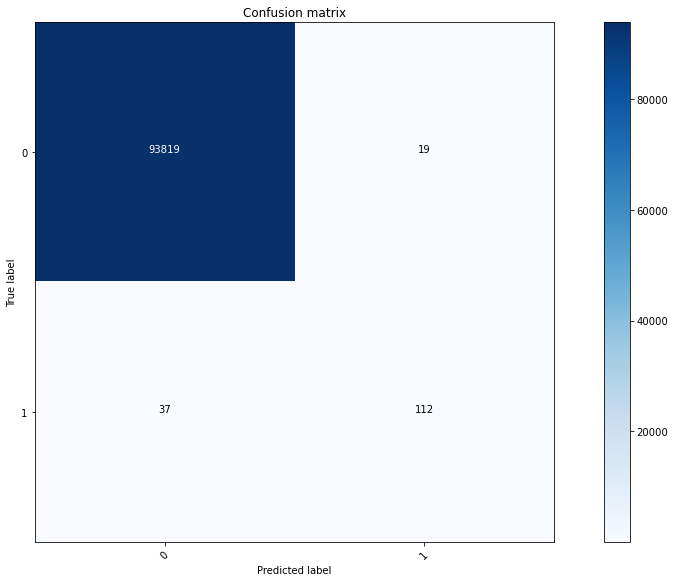

In [140]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [141]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Neural Network model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 112 / 149
Total non-fraudulent transactions detected: 93819 / 93838
Probability to detect a fraudulent transaction: 0.7516778523489933
Probability to detect a non-fraudulent transaction: 0.9997975233913766
Accuracy of the Neural Network model : 99.94041729175312%
ROC_AUC_score : 0.875738


In [142]:
print(classification_report(y_test,predictions))   # f1 - score - 0.80 the best among all

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.85      0.75      0.80       149

    accuracy                           1.00     93987
   macro avg       0.93      0.88      0.90     93987
weighted avg       1.00      1.00      1.00     93987



### ANN with oversampled smote data

In [143]:
model.fit(x_smote, y_smote, epochs=10, batch_size=10)

Epoch 1/10
38096/38096 [==============================] - 57s 1ms/step - loss: 0.0304 - accuracy: 0.9897
Epoch 2/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0179 - accuracy: 0.9945
Epoch 3/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0139 - accuracy: 0.9957
Epoch 4/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0121 - accuracy: 0.9965
Epoch 5/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0111 - accuracy: 0.9969
Epoch 6/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0093 - accuracy: 0.9974
Epoch 7/10
38096/38096 [==============================] - 57s 1ms/step - loss: 0.0088 - accuracy: 0.9977
Epoch 8/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0084 - accuracy: 0.9978
Epoch 9/10
38096/38096 [==============================] - 56s 1ms/step - loss: 0.0075 - accuracy: 0.9980
Epoch 10/10
38096/38096 [==============================

In [144]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2938/2938 [==============================] - 2s 752us/step - loss: 0.0193 - accuracy: 0.9978
Accuracy: 99.78


In [145]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(93987,)

In [146]:
# make class predictions with the model
predictions = model.predict_classes(X_test)
predictions.shape

(93987, 1)

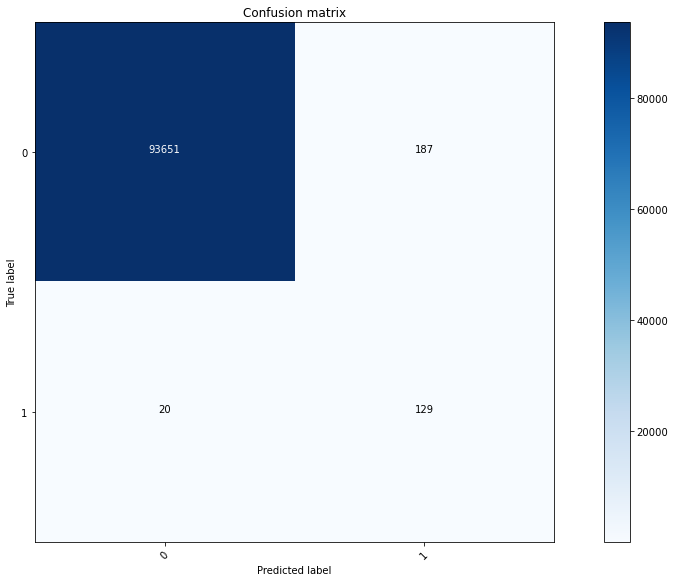

In [147]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [148]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Neural Network model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 129 / 149
Total non-fraudulent transactions detected: 93651 / 93838
Probability to detect a fraudulent transaction: 0.8657718120805369
Probability to detect a non-fraudulent transaction: 0.9980072039046015
Accuracy of the Neural Network model : 99.77975677487312%
ROC_AUC_score : 0.931890


In [149]:
print(classification_report(y_test,predictions))   # f1 - score - 0.84 the best among all

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.41      0.87      0.55       149

    accuracy                           1.00     93987
   macro avg       0.70      0.93      0.78     93987
weighted avg       1.00      1.00      1.00     93987



### ANN has shown decrease in F1 score on oversampled data

# Random Forest - for full 100% data

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [110]:
model.fit(X_train,y_train)

RandomForestClassifier()

In [111]:
predictions = model.predict(X_test)

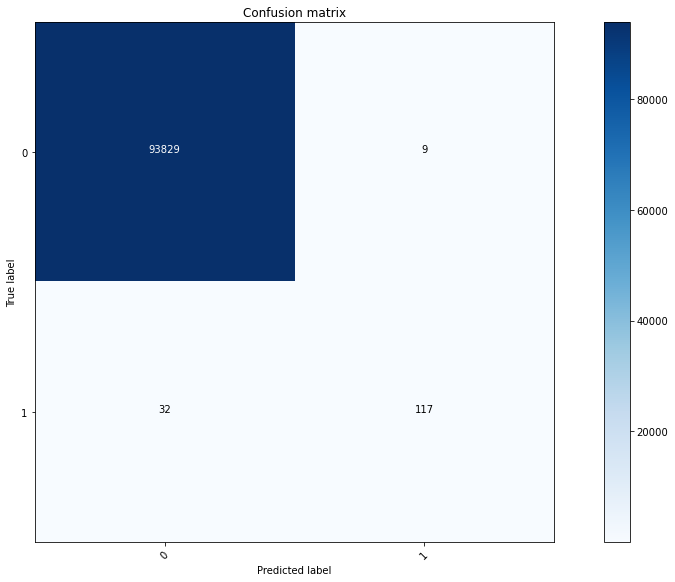

In [112]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [113]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Random Forest model : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 117 / 149
Total non-fraudulent transactions detected: 93829 / 93838
Probability to detect a fraudulent transaction: 0.785234899328859
Probability to detect a non-fraudulent transaction: 0.9999040900274941
Accuracy of the Random Forest model : 99.95637694574782%
ROC_AUC_score : 0.892569


In [75]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18769
           1       1.00      0.83      0.91        29

    accuracy                           1.00     18798
   macro avg       1.00      0.91      0.95     18798
weighted avg       1.00      1.00      1.00     18798



In [76]:
#Create independent and Dependent Features
columns = data.columns.tolist()  # all columns
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]   # removing "Class" from our columns list
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 28)
(284807,)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# Under sampling

In [30]:
import imblearn

In [80]:
from imblearn.under_sampling import RandomUnderSampler

In [81]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

In [82]:
x_rus, y_rus = rus.fit_resample(X_train, y_train)

In [84]:
from collections import Counter
print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 190477, 1: 343})
Resample dataset shape Counter({0: 343, 1: 343})


In [86]:
model.fit(x_rus,y_rus)

RandomForestClassifier()

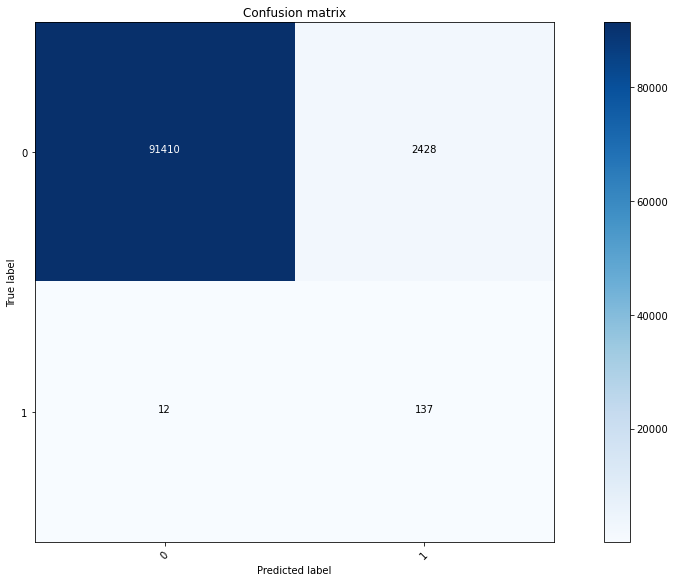

In [87]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [88]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Random Forest model with Under sampling : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 137 / 149
Total non-fraudulent transactions detected: 91410 / 93838
Probability to detect a fraudulent transaction: 0.9194630872483222
Probability to detect a non-fraudulent transaction: 0.9741256207506553
Accuracy of the Random Forest model with Under sampling : 97.40389628352857%
ROC_AUC_score : 0.946794


In [90]:
print(classification_report(y_test,predictions))
# F1- Score = 0.1 which is very Bad

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     93838
           1       0.05      0.92      0.10       149

    accuracy                           0.97     93987
   macro avg       0.53      0.95      0.54     93987
weighted avg       1.00      0.97      0.99     93987



# Over sampling

In [91]:
from imblearn.over_sampling import RandomOverSampler

In [103]:
ros = RandomOverSampler(0.5,random_state=42)

/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:638: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [104]:
x_ros, y_ros = ros.fit_resample(X_train, y_train)

In [105]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 190477, 1: 343})
Resample dataset shape Counter({0: 190477, 1: 95238})


In [106]:
print(X_train.shape)
print(y_train.shape)
print(x_ros.shape)
print(y_ros.shape)
print(X_test.shape)
print(y_test.shape)

(190820, 28)
(190820,)
(285715, 28)
(285715,)
(93987, 28)
(93987,)


In [107]:
model.fit(x_ros,y_ros)

RandomForestClassifier()

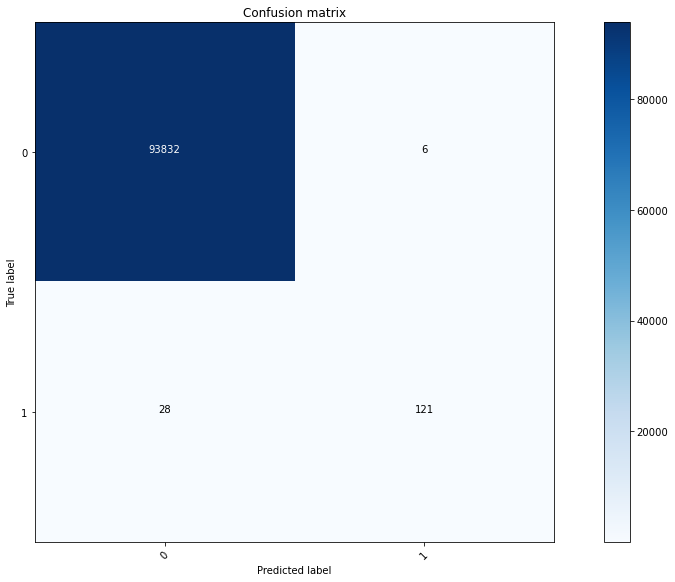

In [108]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [109]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Random Forest model with Over sampling : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 121 / 149
Total non-fraudulent transactions detected: 93832 / 93838
Probability to detect a fraudulent transaction: 0.8120805369127517
Probability to detect a non-fraudulent transaction: 0.9999360600183295
Accuracy of the Random Forest model with Over sampling : 99.96382478427867%
ROC_AUC_score : 0.906008


In [59]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93775
           1       1.00      1.00      1.00     93873

    accuracy                           1.00    187648
   macro avg       1.00      1.00      1.00    187648
weighted avg       1.00      1.00      1.00    187648



# Conclusion:
### Undersampling will give us better proabability to detect a fraudulent transaction because we have decrease the data set very much but will not be effective as it giver very very bad F1-score of about 0.01
### Oversampling is better overall, as it alsp gives more probability to detect a fraudulent transaction and an overall increase in the F1-score also.
### Proabability to detect fraudulent transaction ~ 82% ( For Random Forest, ANN would then give even better) 
### Overall Accuracy - 99.42%

# lets use some other methods for balancing the data

## SMOTE - Synthetic Minority Oversampling Technique

In [114]:
from imblearn.over_sampling import SMOTE

In [115]:
smote = SMOTE()

In [117]:
x_smote, y_smote = smote.fit_resample(X_train, y_train)

In [118]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 190477, 1: 343})
Resample dataset shape Counter({0: 190477, 1: 190477})


In [119]:
model.fit(x_smote,y_smote)

RandomForestClassifier()

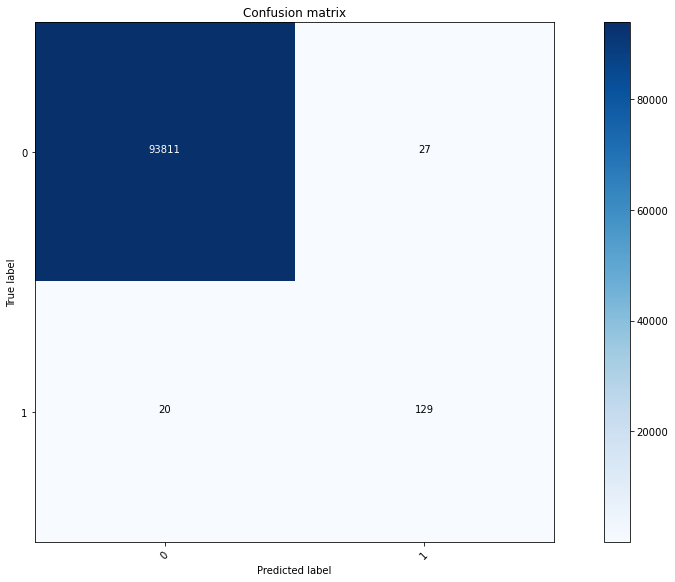

In [120]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm,classes)

In [121]:
print('Total fraudulent transactions detected: ' + str(cm[1][1]) + ' / ' + str(cm[1][1]+cm[1][0]))
print('Total non-fraudulent transactions detected: ' + str(cm[0][0]) + ' / ' + str(cm[0][1]+cm[0][0]))

print('Probability to detect a fraudulent transaction: ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print('Probability to detect a non-fraudulent transaction: ' + str(cm[0][0]/(cm[0][1]+cm[0][0])))

print("Accuracy of the Random Forest model with Over sampling : "+str(100*(cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))) + "%")
print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, predictions)))

Total fraudulent transactions detected: 129 / 149
Total non-fraudulent transactions detected: 93811 / 93838
Probability to detect a fraudulent transaction: 0.8657718120805369
Probability to detect a non-fraudulent transaction: 0.9997122700824825
Accuracy of the Random Forest model with Over sampling : 99.94999308414994%
ROC_AUC_score : 0.932742


In [122]:
print(classification_report(y_test,predictions))  # F1 - score - 0.85

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.83      0.87      0.85       149

    accuracy                           1.00     93987
   macro avg       0.91      0.93      0.92     93987
weighted avg       1.00      1.00      1.00     93987

